IRR Analysis for Patient Responsibilities
===

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
from collections import Counter
import itertools
import nltk
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [4]:
import sys
sys.path.append("../../annotation_data")

In [5]:
from responsibility import get_responsibility_annotations_by_username, responsibility_labels, responsibility_label_to_code_map, get_annotated_responsibility_df
from utils import get_webclient_url

In [6]:
responsibility_annotations = get_responsibility_annotations_by_username()
len(responsibility_annotations)

3126

In [7]:
responsibility_annotations[0]

{'site_id': 715191,
 'journal_oid': '5272895da689b4cf36c142a5',
 'username': 'levon003',
 'responsibilities': ['sharing_medical_info'],
 'is_corrected': False}

In [8]:
df = pd.DataFrame(responsibility_annotations)
len(df)

3126

In [9]:
df.head(n=3)

,is_corrected,journal_oid,responsibilities,site_id,username
0,False,5272895da689b4cf36c142a5,[sharing_medical_info],715191,levon003
1,False,525f036d0dad103249c4a209,[sharing_medical_info],719363,levon003
2,False,52a24586ac7ee95c507d4602,[],839384,levon003


In [10]:
Counter(df['is_corrected']).most_common()

[(False, 3102), (True, 24)]

In [18]:
df = df[df['is_corrected'] == False]
len(df)

3102

In [19]:
irr_sites = []
irr_set_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/eriks074"
for filename in os.listdir(irr_set_dir):
    if filename == "multiset_4_20181206.txt":
        continue
    irr_filepath = os.path.join(irr_set_dir, filename)
    with open(irr_filepath, 'r') as infile:
        lines = infile.readlines()[1:]  # take all the lines, minus the header
        site_ids = [int(line) for line in lines if line.strip() != ""]
        print(f"Added {len(site_ids)} sites from IRR file '{filename}'.")
        irr_sites.extend(site_ids)
len(irr_sites)

Added 10 sites from IRR file 'irr_set_3_20180830.txt'.
Added 20 sites from IRR file 'phases_set_4_20180904.txt'.
Added 20 sites from IRR file 'multiset_1_20181009.txt'.
Added 20 sites from IRR file 'multiset_3_20181019.txt'.


70

In [20]:
irr_df = df[df['site_id'].isin(irr_sites)]
len(irr_df)

2009

In [39]:
def get_agreement_df(user1, user2, df=None):
    agreements_list = []
    for key, group in df.groupby(by=["site_id", "journal_oid"]):
        if len(group) <= 1:
            continue
        annotating_users = set(group['username'])
        if user1 not in annotating_users or user2 not in annotating_users:
            continue
        site_id, journal_oid = key

        user1_responsibilities = group[group['username'] == user1].iloc[0]['responsibilities']
        user2_responsibilities = group[group['username'] == user2].iloc[0]['responsibilities']

        if 'none' in user1_responsibilities:
            user1_responsibilities.remove('none')
        if 'none' in user2_responsibilities:
            user2_responsibilities.remove('none')
            
        user1_responsibility_str = "|".join(user1_responsibilities)
        user2_responsibility_str = "|".join(user2_responsibilities)

        agreement_score = 0
        is_strict_agreement = len(set(user1_responsibilities) & set(user2_responsibilities)) == max(len(user1_responsibilities), len(user2_responsibilities))
        is_partial_agreement = len(set(user1_responsibilities) & set(user2_responsibilities)) > 0 or len(user1_responsibilities) == len(user2_responsibilities)

        agreement = {
            "site_id": site_id,
            "journal_oid": journal_oid,
            "user1": user1,
            "user2": user2,
            "user1_responsibilities": user1_responsibilities,
            "user2_responsibilities": user2_responsibilities,
            "user1_responsibility_str": user1_responsibility_str,
            "user2_responsibility_str": user2_responsibility_str,
            "is_strict_agreement": is_strict_agreement,
            "is_partial_agreement": is_partial_agreement
        }
        agreements_list.append(agreement)
    agreement_df = pd.DataFrame(agreements_list)
    return agreement_df

In [26]:
user1 = "eriks074"
user2 = "luoxx498"
agreement_df = get_agreement_df(user1, user2)
len(agreement_df)

975

In [27]:
agreement_df.head()

,is_partial_agreement,is_strict_agreement,journal_oid,site_id,user1,user1_responsibilities,user1_responsibility_str,user2,user2_responsibilities,user2_responsibility_str
0,True,False,51be1cc26ca004675000a798,138616,eriks074,"[symptom_management, compliance]",symptom_management|compliance,luoxx498,"[info_filtering, preparation, symptom_manageme...",info_filtering|preparation|symptom_management|...
1,True,False,51be1cc26ca004675000a7fa,138616,eriks074,[symptom_management],symptom_management,luoxx498,"[preparation, symptom_management, sharing_medi...",preparation|symptom_management|sharing_medical...
2,True,False,51be1cc26ca004675000a9dc,138616,eriks074,"[symptom_management, sharing_medical_info, com...",symptom_management|sharing_medical_info|compli...,luoxx498,"[info_filtering, preparation, symptom_manageme...",info_filtering|preparation|symptom_management|...
3,False,False,51be1cc26ca004675000aa78,138616,eriks074,[],,luoxx498,[symptom_management],symptom_management
4,True,False,51be1cc26ca004675000aa7a,138616,eriks074,"[symptom_management, compliance]",symptom_management|compliance,luoxx498,"[symptom_management, sharing_medical_info, com...",symptom_management|sharing_medical_info|compli...


In [38]:
def get_strict_agreement_accuracy(df):
    acc = np.sum(df['is_strict_agreement']) / len(df)
    return acc

def get_partial_agreement_accuracy(df):
    acc = np.sum(df['is_partial_agreement']) / len(df)
    return acc

In [21]:
get_strict_agreement_accuracy(agreement_df)

0.19384615384615383

In [22]:
get_partial_agreement_accuracy(agreement_df)

0.9056410256410257

In [23]:
sklearn.metrics.cohen_kappa_score(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"])

0.12315529081701548

In [24]:
usernames = ["levon003", "eriks074", "rubya001", "vachh007", "luoxx498"]
for user1, user2 in itertools.combinations(usernames, 2):
    agreement_df = get_agreement_df(user1, user2)
    if len(agreement_df) == 0:
        continue
    num_sites = len(set(agreement_df["site_id"]))
    strict_acc = get_strict_agreement_accuracy(agreement_df)
    partial_acc = get_partial_agreement_accuracy(agreement_df)
    
    cohen_kappa = sklearn.metrics.cohen_kappa_score(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"])
    
    print(f"{user1}/{user2}\ts={num_sites:2},j={len(agreement_df):3}\t{strict_acc:.2f}\t{partial_acc:.2f}\t{cohen_kappa:.2f}")

levon003/eriks074	s= 6,j= 18	0.17	0.78	0.11
levon003/rubya001	s= 6,j= 18	0.17	0.89	0.12
levon003/luoxx498	s= 6,j= 18	0.33	0.94	0.29
eriks074/rubya001	s=10,j=139	0.11	0.87	0.08
eriks074/luoxx498	s=48,j=975	0.19	0.91	0.12
rubya001/luoxx498	s=10,j=139	0.24	0.92	0.18


In [78]:
user1 = "eriks074"
user2 = "luoxx498"
agreement_df = get_agreement_df(user1, user2, df)
len(agreement_df)

975

In [79]:
classes = list(set(agreement_df["user1_responsibility_str"]) | set(agreement_df["user2_responsibility_str"]))
classes[:5]

['',
 'communicating|symptom_management|sharing_medical_info|compliance|managing_transitions',
 'sharing_medical_info|managing_transitions|giving_back',
 'info_filtering|clinical_decisions|sharing_medical_info|compliance',
 'clinical_decisions|sharing_medical_info|compliance']

In [80]:
sklearn.metrics.confusion_matrix(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"], labels=classes)

array([[42,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [81]:
resp_counts = Counter()
for resps in df["responsibilities"]:
    resp_counts.update(resps)
resp_counts.most_common()

[('sharing_medical_info', 2474),
 ('compliance', 2162),
 ('symptom_management', 746),
 ('preparation', 491),
 ('managing_transitions', 395),
 ('coordinating_support', 334),
 ('info_filtering', 255),
 ('continued_monitoring', 171),
 ('clinical_decisions', 127),
 ('giving_back', 98),
 ('behavior_changes', 91),
 ('financial_management', 71),
 ('communicating', 40)]

In [82]:
print("Responsibility\t\t\tAP\tAA\tDisagree")
print("="*60)
for resp, total_count in resp_counts.most_common():
    resp_set = set([resp])
    user1_present = agreement_df.user1_responsibilities.map(resp_set.issubset)
    user2_present = agreement_df.user2_responsibilities.map(resp_set.issubset)
    resp_present = user1_present | user2_present
    resp_match = user1_present == user2_present
    
    agree_absent = np.sum(resp_match & ~resp_present)
    agree_present = np.sum(resp_match & resp_present)
    disagree = np.sum(user1_present != user2_present)
    print(f"{resp:30}\t{agree_present:3}\t{agree_absent:3}\t{disagree:3}")

Responsibility			AP	AA	Disagree
sharing_medical_info          	740	 93	142
compliance                    	620	119	236
symptom_management            	 96	597	282
preparation                   	 44	700	231
managing_transitions          	 14	765	196
coordinating_support          	 52	805	118
info_filtering                	 18	808	149
continued_monitoring          	 12	898	 65
clinical_decisions            	 19	913	 43
giving_back                   	 11	930	 34
behavior_changes              	  9	927	 39
financial_management          	 11	942	 22
communicating                 	  0	957	 18


## Summary stats between users

In [83]:
user1, user2

('eriks074', 'luoxx498')

In [84]:
u1_resp_counts = [len(rl) for rl in agreement_df["user1_responsibilities"]]
u2_resp_counts = [len(rl) for rl in agreement_df["user2_responsibilities"]]

In [85]:
np.mean(u1_resp_counts), np.mean(u2_resp_counts)

(2.3374358974358973, 2.654358974358974)

In [86]:
np.std(u1_resp_counts), np.std(u2_resp_counts)

(1.1608942573120484, 1.2578039366023155)

In [87]:
cov = np.cov(np.array([u1_resp_counts, u2_resp_counts]).T)
np.min(cov), np.max(cov), cov.shape

(-16.0, 32.0, (975, 975))

In [88]:
resps_list = [resp for resp, _ in resp_counts.most_common()]
u1_counts = np.zeros(len(resps_list))
for resps in agreement_df["user1_responsibilities"]:
    for resp in resps:
        u1_counts[resps_list.index(resp)] += 1
        #if "behav" in resp:
        #    print(resp,u1_counts[resps.index(resp)])
u2_counts = np.zeros(len(resps_list))
for resps in agreement_df["user2_responsibilities"]:
    for resp in resps:
        u2_counts[resps_list.index(resp)] += 1
u1_counts, u2_counts

(array([770., 701., 129., 122., 192., 113.,  44.,  68.,  31.,  28.,  36.,
         29.,  16.]),
 array([852., 775., 345., 197.,  32., 109., 141.,  21.,  50.,  28.,  21.,
         15.,   2.]))

In [89]:
print(f"{'responsibility':30}\t{user1}\t{user2}")
print("="*60)
for i, resp in enumerate(resps_list):
    print(f"{resp:30}\t{u1_counts[i]:8}\t{u2_counts[i]:8}")

responsibility                	eriks074	luoxx498
sharing_medical_info          	   770.0	   852.0
compliance                    	   701.0	   775.0
symptom_management            	   129.0	   345.0
preparation                   	   122.0	   197.0
managing_transitions          	   192.0	    32.0
coordinating_support          	   113.0	   109.0
info_filtering                	    44.0	   141.0
continued_monitoring          	    68.0	    21.0
clinical_decisions            	    31.0	    50.0
giving_back                   	    28.0	    28.0
behavior_changes              	    36.0	    21.0
financial_management          	    29.0	    15.0
communicating                 	    16.0	     2.0


In [92]:
# Agreement for the individual responsibilities
for i, resp in enumerate(resps_list):
    user1_annotations = agreement_df.user1_responsibilities.apply(lambda resp_list: resp in resp_list)
    user2_annotations = agreement_df.user2_responsibilities.apply(lambda resp_list: resp in resp_list)
    cohen_kappa = sklearn.metrics.cohen_kappa_score(user1_annotations, user2_annotations)
    print(f"{resp:30} {cohen_kappa:.2f}")

sharing_medical_info           0.49
compliance                     0.35
symptom_management             0.26
preparation                    0.14
managing_transitions           0.07
coordinating_support           0.40
info_filtering                 0.14
continued_monitoring           0.24
clinical_decisions             0.45
giving_back                    0.37
behavior_changes               0.30
financial_management           0.49
communicating                  -0.00


In [93]:
target_resp = "coordinating_support"
resp_set = set([target_resp])
user1_present = agreement_df.user1_responsibilities.map(resp_set.issubset)
user2_present = agreement_df.user2_responsibilities.map(resp_set.issubset)
disagree = user1_present != user2_present
len(agreement_df[disagree])

118

In [41]:
print(target_resp, "Disagreements")
print("="*40)
for index, row in agreement_df[disagree].iterrows():
    site_id = row["site_id"]
    journal_oid = row["journal_oid"]
    webclient_url = "http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/%d#%s" % (site_id, journal_oid)
    user1_tagged = target_resp in row["user1_responsibilities"]
    user2_tagged = target_resp in row["user2_responsibilities"]
    assert user1_tagged or user2_tagged
    tagging_user = user1 if user1_tagged else user2
    print(tagging_user, webclient_url)

coordinating_support Disagreements
luoxx498 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/139736#51be1d0a6ca0043b5100d66f
luoxx498 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/159835#51be22b86ca0042163010115
luoxx498 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/161454#51be22ef6ca004de630111c7
eriks074 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/161454#51be22ef6ca004de63011309
eriks074 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/161454#51be22ef6ca004de63011369
luoxx498 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/181230#51be27a96ca004047300d12a
eriks074 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/181230#51be27a96ca004047300d3b6
luoxx498 http://127.0.0.1:5000/conflict/journal/responsibilities/eriks074/vs/luoxx498/site/181230#51be27

#### Tasks to do

Small code snippet for producing the URLs for tasks to give to Drew and Wenqi

In [7]:
tasks_to_do = ["symptom_management", "preparation", "managing_transitions", "info_filtering", "continued_monitoring", "clinical_decisions"]
tasks_to_do

['symptom_management',
 'preparation',
 'managing_transitions',
 'info_filtering',
 'continued_monitoring',
 'clinical_decisions']

In [9]:
for url_base in ["http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/", 
                 "http://127.0.0.1:5000/discussion/journal/summary/luoxx498/eriks074/responsibility/"]:
    for task in tasks_to_do:
        task_url = url_base + task
        print(task_url)

http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/symptom_management
http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/preparation
http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/managing_transitions
http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/info_filtering
http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/continued_monitoring
http://127.0.0.1:5000/discussion/journal/summary/eriks074/luoxx498/responsibility/clinical_decisions
http://127.0.0.1:5000/discussion/journal/summary/luoxx498/eriks074/responsibility/symptom_management
http://127.0.0.1:5000/discussion/journal/summary/luoxx498/eriks074/responsibility/preparation
http://127.0.0.1:5000/discussion/journal/summary/luoxx498/eriks074/responsibility/managing_transitions
http://127.0.0.1:5000/discussion/journal/summary/luoxx498/eriks074/responsibility/info_filtering
http:/

## IRR analysis of December 2018 IRR set

Completed after a round of discussion.

```
RESPONSIBILITY		           K   	Change		Discussed?
sharing_medical_info           0.55 	UP 0.06		NO
compliance                     0.46 	UP 0.11		NO
preparation                    0.21 	UP 0.07		YES
symptom_management             0.14 	DOWN 0.12	YES
managing_transitions           0.12 	UP 0.05		YES
coordinating_support           0.42 	UP 0.02		YES
info_filtering                 0.08 	DOWN 0.06	YES
continued_monitoring           0.37 	UP 0.13		YES
giving_back                    0.41 	UP 0.04		NO
behavior_changes               0.43 	UP 0.13		NO
clinical_decisions             0.20 	DOWN 0.25	YES
financial_management           0.46 	DOWN 0.03	NO
communicating                  -0.00	NO CHANGE	NO
```

In [32]:
irr_filepath = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/annotation_data/assignments/luoxx498/multiset_4_20181206.txt"

In [33]:
with open(irr_filepath, 'r') as infile:
    infile.readline()
    irr_site_ids = [int(line.strip()) for line in infile]
len(irr_site_ids), irr_site_ids

(20,
 [161454,
  537539,
  230820,
  921385,
  302124,
  198138,
  561373,
  820897,
  376170,
  197260,
  181230,
  630153,
  376466,
  186370,
  812280,
  139736,
  225553,
  322976,
  635531,
  192780])

In [34]:
df = new_df

In [35]:
irr_df = df[df['site_id'].isin(irr_site_ids)]
len(irr_df)

1036

In [36]:
non_irr_df = df[~df['site_id'].isin(irr_site_ids)]
len(non_irr_df)

2090

In [40]:
user1 = "eriks074"
user2 = "luoxx498"
agreement_df = get_agreement_df(user1, user2, irr_df)
len(agreement_df)

471

In [41]:
non_irr_agreement_df = get_agreement_df(user1, user2, non_irr_df)
len(non_irr_agreement_df)

573

In [42]:
print(user1, len(non_irr_df[non_irr_df.username == user1]))
print(user2, len(non_irr_df[non_irr_df.username == user2]))



eriks074 1290
luoxx498 574


In [43]:
agreement_df.head()

,is_partial_agreement,is_strict_agreement,journal_oid,site_id,user1,user1_responsibilities,user1_responsibility_str,user2,user2_responsibilities,user2_responsibility_str
0,False,False,51be1d0a6ca0043b5100cf7d,139736,eriks074,[preparation],preparation,luoxx498,[],
1,True,False,51be1d0a6ca0043b5100d66f,139736,eriks074,"[sharing_medical_info, compliance, behavior_ch...",sharing_medical_info|compliance|behavior_changes,luoxx498,"[coordinating_support, sharing_medical_info, c...",coordinating_support|sharing_medical_info|comp...
2,True,False,51be1d0a6ca0043b5100d76d,139736,eriks074,"[sharing_medical_info, compliance]",sharing_medical_info|compliance,luoxx498,"[preparation, sharing_medical_info, compliance]",preparation|sharing_medical_info|compliance
3,True,False,51be1d0a6ca0043b5100d85f,139736,eriks074,[compliance],compliance,luoxx498,"[preparation, sharing_medical_info, compliance]",preparation|sharing_medical_info|compliance
4,True,False,51be1d0a6ca0043b5100d94d,139736,eriks074,"[sharing_medical_info, compliance, managing_tr...",sharing_medical_info|compliance|managing_trans...,luoxx498,"[sharing_medical_info, compliance]",sharing_medical_info|compliance


In [44]:
classes = list(set(agreement_df["user1_responsibility_str"]) | set(agreement_df["user2_responsibility_str"]))
classes

['',
 'symptom_management|sharing_medical_info',
 'sharing_medical_info|compliance|managing_transitions|continued_monitoring',
 'sharing_medical_info|compliance',
 'preparation|managing_transitions',
 'preparation|sharing_medical_info|compliance|giving_back',
 'sharing_medical_info|giving_back',
 'preparation|symptom_management|sharing_medical_info|compliance|behavior_changes',
 'coordinating_support|compliance',
 'symptom_management|sharing_medical_info|compliance|giving_back',
 'info_filtering|preparation|sharing_medical_info|compliance|managing_transitions',
 'sharing_medical_info|compliance|behavior_changes',
 'coordinating_support|giving_back',
 'sharing_medical_info|managing_transitions|financial_management',
 'info_filtering|clinical_decisions|sharing_medical_info|compliance',
 'preparation|sharing_medical_info',
 'managing_transitions',
 'symptom_management|sharing_medical_info|compliance|managing_transitions',
 'coordinating_support|sharing_medical_info|compliance|financial_ma

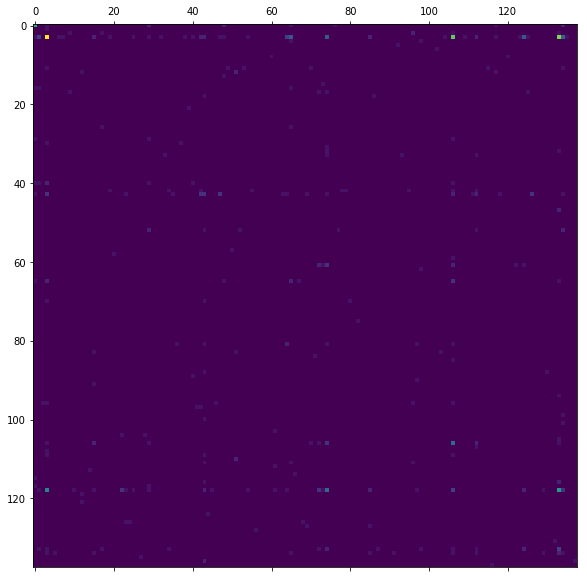

In [45]:
conf_mat = sklearn.metrics.confusion_matrix(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"], labels=classes)
conf_mat_normed = np.log(conf_mat / (np.max(conf_mat)) + 1)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(conf_mat_normed)
plt.show()

In [46]:
sklearn.metrics.cohen_kappa_score(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"])

0.10233267744603192

In [47]:
1 - np.sum(agreement_df['is_strict_agreement']) / len(agreement_df)

0.851380042462845

In [48]:
resp_counts = Counter()
for resps in irr_df["responsibilities"]:
    resp_counts.update(resps)
resp_counts.most_common()

[('sharing_medical_info', 906),
 ('compliance', 835),
 ('preparation', 250),
 ('symptom_management', 197),
 ('managing_transitions', 178),
 ('coordinating_support', 163),
 ('info_filtering', 104),
 ('continued_monitoring', 48),
 ('giving_back', 45),
 ('behavior_changes', 42),
 ('clinical_decisions', 35),
 ('financial_management', 28),
 ('communicating', 8)]

In [49]:
print("Responsibility\t\t\tAP\tAA\tDisagree")
print("="*60)
for resp, total_count in resp_counts.most_common():
    resp_set = set([resp])
    user1_present = agreement_df.user1_responsibilities.map(resp_set.issubset)
    user2_present = agreement_df.user2_responsibilities.map(resp_set.issubset)
    resp_present = user1_present | user2_present
    resp_match = user1_present == user2_present
    
    agree_absent = np.sum(resp_match & ~resp_present)
    agree_present = np.sum(resp_match & resp_present)
    disagree = np.sum(user1_present != user2_present)
    print(f"{resp:30}\t{agree_present:3}\t{agree_absent:3}\t{disagree:3}")

Responsibility			AP	AA	Disagree
sharing_medical_info          	388	 38	 45
compliance                    	340	 50	 81
preparation                   	 44	271	156
symptom_management            	 22	302	147
managing_transitions          	 18	334	119
coordinating_support          	 41	356	 74
info_filtering                	  7	375	 89
continued_monitoring          	  6	442	 23
giving_back                   	 10	436	 25
behavior_changes              	  8	444	 19
clinical_decisions            	  4	441	 26
financial_management          	  5	453	 13
communicating                 	  0	463	  8


In [50]:
num_sites = len(set(agreement_df["site_id"]))
strict_acc = get_strict_agreement_accuracy(agreement_df)
partial_acc = get_partial_agreement_accuracy(agreement_df)
    
cohen_kappa = sklearn.metrics.cohen_kappa_score(agreement_df["user1_responsibility_str"], agreement_df["user2_responsibility_str"])
    
print(f"{user1}/{user2}\ts={num_sites:2},j={len(agreement_df):3}\t{strict_acc:.2f}\t{partial_acc:.2f}\t{cohen_kappa:.2f}")

eriks074/luoxx498	s=19,j=471	0.15	0.93	0.10


In [51]:
resps_list = [resp for resp, _ in resp_counts.most_common()]
u1_counts = np.zeros(len(resps_list))
for resps in agreement_df["user1_responsibilities"]:
    for resp in resps:
        u1_counts[resps_list.index(resp)] += 1
        #if "behav" in resp:
        #    print(resp,u1_counts[resps.index(resp)])
u2_counts = np.zeros(len(resps_list))
for resps in agreement_df["user2_responsibilities"]:
    for resp in resps:
        u2_counts[resps_list.index(resp)] += 1
u1_counts, u2_counts

(array([411., 398.,  57.,  27., 120.,  83.,  25.,  26.,  21.,  20.,   8.,
         17.,   6.]),
 array([410., 363., 187., 164.,  35.,  73.,  78.,   9.,  24.,  15.,  26.,
          6.,   2.]))

In [52]:
print(f"{'responsibility':30}\t{user1}\t{user2}")
print("="*60)
for i, resp in enumerate(resps_list):
    print(f"{resp:30}\t{u1_counts[i]:8}\t{u2_counts[i]:8}")

responsibility                	eriks074	luoxx498
sharing_medical_info          	   411.0	   410.0
compliance                    	   398.0	   363.0
preparation                   	    57.0	   187.0
symptom_management            	    27.0	   164.0
managing_transitions          	   120.0	    35.0
coordinating_support          	    83.0	    73.0
info_filtering                	    25.0	    78.0
continued_monitoring          	    26.0	     9.0
giving_back                   	    21.0	    24.0
behavior_changes              	    20.0	    15.0
clinical_decisions            	     8.0	    26.0
financial_management          	    17.0	     6.0
communicating                 	     6.0	     2.0


In [53]:
# compute cohen's kappa per-responsibility
for i, resp in enumerate(responsibility_labels):
    user1_annotations = agreement_df.user1_responsibilities.apply(lambda resp_list: resp in resp_list)
    user2_annotations = agreement_df.user2_responsibilities.apply(lambda resp_list: resp in resp_list)
    disagreement = 1 - (np.sum(user1_annotations == user2_annotations) / len(agreement_df))
    cohen_kappa = sklearn.metrics.cohen_kappa_score(user1_annotations, user2_annotations)
    print(f"{resp:30} {disagreement*100:5.2f}%  {cohen_kappa:5.2f}")

communicating                   1.70%  -0.01
info_filtering                 18.90%   0.06
clinical_decisions              5.52%   0.21
preparation                    33.12%   0.22
symptom_management             31.21%   0.15
coordinating_support           15.71%   0.43
sharing_medical_info            9.55%   0.57
compliance                     17.20%   0.45
managing_transitions           25.27%   0.13
financial_management            2.76%   0.42
continued_monitoring            4.88%   0.32
giving_back                     5.31%   0.42
behavior_changes                4.03%   0.44


In [54]:
print("Responsibility\t\t\tAP\tAA\tDisagree\tPct Agreement\tKappa\tAlpha\tCode")
print("="*100)
for resp, total_count in resp_counts.most_common():
    resp_set = set([resp])
    user1_present = agreement_df.user1_responsibilities.map(resp_set.issubset)
    user2_present = agreement_df.user2_responsibilities.map(resp_set.issubset)
    resp_present = user1_present | user2_present
    resp_match = user1_present == user2_present
    
    agree_absent = np.sum(resp_match & ~resp_present)
    agree_present = np.sum(resp_match & resp_present)
    disagree = np.sum(user1_present != user2_present)
    
    user1_annotations = agreement_df.user1_responsibilities.apply(lambda resp_list: resp in resp_list).astype(int)
    user2_annotations = agreement_df.user2_responsibilities.apply(lambda resp_list: resp in resp_list).astype(int)
    assert len(user1_annotations) == len(user2_annotations)
    cohen_kappa = sklearn.metrics.cohen_kappa_score(user1_annotations, user2_annotations)
    
    nltk_data = []
    for i in range(len(user1_annotations)):
        nltk_data.append((user1, i, user1_annotations.iloc[i]))
        nltk_data.append((user2, i, user2_annotations.iloc[i]))
    agreement = nltk.agreement.AnnotationTask(data=nltk_data)
    krippendorff_alpha = agreement.alpha()
    
    # quick confirmation that Cohen's kappa produced by NLTK and sklearn are the same
    assert np.isclose(agreement.kappa(), cohen_kappa)
    #print(resp)
    #print("kappa " + str(agreement.kappa()))
    #print("fleiss " + str(agreement.multi_kappa()))
    #print("alpha " + str(agreement.alpha()))
    #print("scotts " + str(agreement.pi()))
    
    code = responsibility_label_to_code_map[resp]
    print(f"{resp:30}\t{agree_present:3}\t{agree_absent:3}\t{disagree:8}\t{(agree_present + agree_absent) / (agree_present + agree_absent + disagree):13.2f}\t{cohen_kappa:5.2f}\t{krippendorff_alpha:.2f}\t{code}")

Responsibility			AP	AA	Disagree	Pct Agreement	Kappa	Alpha	Code
sharing_medical_info          	388	 38	      45	         0.90	 0.57	0.57	SM
compliance                    	340	 50	      81	         0.83	 0.45	0.45	CP
preparation                   	 44	271	     156	         0.67	 0.22	0.14	PR
symptom_management            	 22	302	     147	         0.69	 0.15	0.04	ST
managing_transitions          	 18	334	     119	         0.75	 0.13	0.08	MT
coordinating_support          	 41	356	      74	         0.84	 0.43	0.43	CS
info_filtering                	  7	375	      89	         0.81	 0.06	0.03	IF
continued_monitoring          	  6	442	      23	         0.95	 0.32	0.32	CM
giving_back                   	 10	436	      25	         0.95	 0.42	0.42	GB
behavior_changes              	  8	444	      19	         0.96	 0.44	0.44	BC
clinical_decisions            	  4	441	      26	         0.94	 0.21	0.21	CD
financial_management          	  5	453	      13	         0.97	 0.42	0.42	FM
communicating            

## Computing overall occurrence and disagreement proportions

In [27]:
df.head()

,is_corrected,journal_oid,responsibilities,site_id,username
0,False,53851470ca16b4c21b5d4f21,"[communicating, sharing_medical_info, compliance]",714287,naray114
1,False,538534b3ca16b4b31c5d5049,"[sharing_medical_info, giving_back]",714287,naray114
2,False,53afa4dfa589b44503115475,[financial_management],714287,naray114
3,False,537564b6cb16b4c576c37e98,"[sharing_medical_info, compliance]",812280,luoxx498
4,False,531e3abbac7ee9ba0a0fa490,"[symptom_management, sharing_medical_info, com...",812280,luoxx498


In [41]:
resp_counts = np.zeros(len(responsibility_labels))
resp_disagreements = np.zeros(len(responsibility_labels))
multiple_annotator_count = 0  # tracks number of journals with multiple annotators
total_disagreements = 0
none_count = 0
for key, group in tqdm(df.groupby(by=('site_id', 'journal_oid'), sort=False)):
    all_resps = set()
    for resp_list in group.responsibilities:
        all_resps.update(resp_list)
    if len(all_resps) == 0:
        none_count += 1
        continue  # if all annotators indicated none, there's nothing else to do here
    for i, resp_label in enumerate(responsibility_labels):
        if resp_label in all_resps:
            resp_counts[i] += 1
    if len(group) >= 2:
        multiple_annotator_count += 1
        disagreement = False
        for i, resp_label in enumerate(responsibility_labels):
            if resp_label in all_resps:
                for resp_list in group.responsibilities:
                    if resp_label not in resp_list:
                        resp_disagreements[i] += 1
                        disagreement = True
                        break
        if disagreement:
            total_disagreements += 1

resp_proportions = resp_counts / len(df)
resp_disagreement_proportions = resp_disagreements / multiple_annotator_count
for i, resp_label in enumerate(responsibility_labels):
    code = responsibility_label_to_code_map[resp_label]
    occurrence = resp_proportions[i]
    disagreement = resp_disagreement_proportions[i]
    print(f"{resp_label:20}  {code:3}  {occurrence*100:.1f}  {disagreement * 100:.1f}")
print()
print(f"Overall disagreement: {total_disagreements / multiple_annotator_count}")
print(f"Non-none proportion: {(1 - (none_count / len(df))) * 100:.2f}")


100%|██████████| 1909/1909 [00:00<00:00, 3529.57it/s]

communicating         CO   1.3  2.3
info_filtering        IF   7.5  17.0
clinical_decisions    CD   3.4  6.1
preparation           PR   14.4  26.2
symptom_management    ST   20.4  32.9
coordinating_support  CS   9.2  12.9
sharing_medical_info  SM   52.4  16.7
compliance            CP   46.6  26.8
managing_transitions  MT   12.3  22.9
financial_management  FM   1.8  2.6
continued_monitoring  CM   5.0  7.4
giving_back           GB   2.6  4.8
behavior_changes      BC   2.6  4.4

Overall disagreement: 0.852
Non-none proportion: 96.19


## Additional IRR analysis during ICWSM R&R (April 2019)


In [9]:
np.sum(df.responsibilities.map(lambda r: len(r) > 1)), np.sum(df.responsibilities.map(lambda r: len(r) > 0)), len(df)

(6, 2881, 3126)

In [44]:
annotated_df = get_annotated_responsibility_df()
len(annotated_df)

100%|██████████| 1913/1913 [00:25<00:00, 74.30it/s] 


1895

In [48]:
# very, very few journals are annotated with more than a single responsibility label
# this seems false, need to investigate
np.sum(annotated_df.responsibilities.map(lambda r: len(r) > 1)), \
np.sum(annotated_df[annotated_df.conflict_status != 'CONFLICT'].responsibilities.map(lambda r: len(r) > 1))

(573, 3)

In [54]:
# Percentage of updates assigned no responsibility
np.sum(annotated_df.responsibilities.map(lambda r: len(r) == 0)) / len(annotated_df)

0.054353562005277044

In [51]:
annotated_df[(annotated_df.conflict_status != 'CONFLICT')&(annotated_df.responsibilities.map(lambda r: len(r) > 1))]

,behavior_changes_score,clinical_decisions_score,communicating_score,compliance_score,conflict_status,continued_monitoring_score,coordinating_support_score,financial_management_score,giving_back_score,info_filtering_score,is_annotated,journal_oid,journal_text,managing_transitions_score,preparation_score,responsibilities,sharing_medical_info_score,site_id,symptom_management_score
469,0.0,0.0,0.0,1.0,SINGLE USER,0.0,0.0,0.0,0.0,0.0,True,51be2e666ca0041c0a00e86b,NEWLINE So much for the timely update! But s...,0.0,0.0,"[sharing_medical_info, compliance]",1.0,208865,0.0
662,0.0,0.0,0.0,1.0,SINGLE USER,0.0,0.0,0.0,0.0,0.0,True,51be33246ca00479190058c3,NEWLINE New Years Eve Day...started with a sl...,0.0,0.0,"[sharing_medical_info, compliance]",1.0,235240,0.0
668,0.0,0.0,0.0,0.0,SINGLE USER,0.0,0.0,0.0,0.0,1.0,True,51be33246ca0047919005975,NEWLINE NEWLINE If you're wondering what t...,0.0,0.0,"[info_filtering, symptom_management]",0.0,235240,1.0


In [10]:
import db as db_utils
import responsibility as responsibility_utils

In [11]:
def get_responsibility_annotations_by_username_dataframe():
    try:
        db = db_utils.get_annotation_db()
        created_at = '2018-08-23'
        cursor = db.execute("""
                    SELECT a.site_id, a.journal_oid, a.data, a.username, a.id
                    FROM journalAnnotation a
                    WHERE a.annotation_type = "journal_patient_responsibilities" AND a.data <> ""
                    AND a.created >= ?
                    GROUP BY a.site_id, a.journal_oid, a.username, a.id
                    ORDER BY a.id DESC
                """, (created_at,))

        responsibility_annotations = []
        rows = cursor.fetchall()
        for row in rows:
            site_id, journal_oid = row['site_id'], row['journal_oid']
            username = row['username']
            responsibilities = responsibility_utils.get_labels_from_responsibility_string(row['data'])
            responsibility_annotation_data = {'site_id': site_id,
                                              'journal_oid': journal_oid,
                                              'username': username,
                                              'responsibilities': responsibilities,
                                              'id': row['id']}
            responsibility_annotations.append(responsibility_annotation_data)
        
        responsibility_df = pd.DataFrame(responsibility_annotations)
        new_df_inds = [group.id.idxmax() 
                       for key, group 
                       in responsibility_df.groupby(by=['site_id', 'journal_oid', 'username'])]
        new_df = responsibility_df.loc[new_df_inds].copy()
        new_df.reset_index(inplace=True)
        
        return new_df
    finally:
        db.close()
        
def get_responsibility_annotations_by_username_adjusted_static():
    # first crack at digging into the problem
    try:
        db = db_utils.get_annotation_db()
        created_at = '2018-08-23'
        cursor = db.execute("""
                    SELECT a.site_id, a.journal_oid, a.data, a.username, c.correct_username 
                    FROM journalAnnotation a LEFT JOIN journalAnnotationConflictResolution c 
                    ON a.site_id = c.site_id AND a.journal_oid = c.journal_oid AND a.annotation_type = c.annotation_type 
                    WHERE a.annotation_type = "journal_patient_responsibilities" AND a.data <> ""
                    AND a.created >= ?
                    GROUP BY a.site_id, a.journal_oid, a.username 
                    ORDER BY a.id DESC
                """, (created_at,))

        responsibility_annotations = []
        rows = cursor.fetchall()
        multiple_resp_count = 0
        for row in rows:
            site_id, journal_oid = row['site_id'], row['journal_oid']
            username = row['username']
            is_corrected = row['correct_username'] is not None and row['correct_username'] != ""
            if '|' in row['data']:
                multiple_resp_count += 1
            responsibilities = responsibility_utils.get_labels_from_responsibility_string(row['data'])
            if len(responsibilities) > 1 or '|' in row['data']:
                print(row['data'])
            responsibility_annotation_data = {'site_id': site_id,
                                              'journal_oid': journal_oid,
                                              'username': username,
                                              'responsibilities': responsibilities,
                                              'is_corrected': is_corrected}
            responsibility_annotations.append(responsibility_annotation_data)
        print("Multiple responsibilities in %d / %d journals." % (multiple_resp_count, len(responsibility_annotations)))
        return responsibility_annotations
    finally:
        db.close()

In [12]:
adj_df = pd.DataFrame(get_responsibility_annotations_by_username_adjusted())
len(adj_df)

9115

In [13]:
adj_df.head()

,id,journal_oid,responsibilities,site_id,username
0,29580,525f036d0dad103249c4a209,"[sharing_medical_info, compliance]",719363,levon003
1,29579,525f036d0dad103249c4a209,[sharing_medical_info],719363,levon003
2,29577,5272895da689b4cf36c142a5,"[sharing_medical_info, compliance, financial_m...",715191,levon003
3,29576,5272895da689b4cf36c142a5,"[sharing_medical_info, compliance, giving_back]",715191,levon003
4,29575,5272895da689b4cf36c142a5,"[sharing_medical_info, compliance]",715191,levon003


In [63]:
len(df)

3102

In [15]:
adj_df['cardinality'] = adj_df.apply(lambda row: len(row.responsibilities), axis=1)

In [55]:
new_df_inds = [group.id.idxmax() for key, group in adj_df.groupby(by=['site_id', 'journal_oid', 'username'])]
len(new_df_inds)

3126

In [57]:
len(adj_df.loc[new_df_inds])

3126

In [12]:
new_df = get_responsibility_annotations_by_username_dataframe()
len(new_df)

3126

In [21]:
new_df_rows = []
cardinality_list = []
for key, group in adj_df.groupby(by=['site_id', 'journal_oid', 'username']):
    
    if len(group) > 1:
        row = group.loc[group.id.idxmax()]
        new_df_rows.append(row)
        cardinality = row.cardinality
    else:
        row = group.iloc[0]
        new_df_rows.append(row)
        cardinality = row.cardinality
    cardinality_list.append(cardinality)

In [22]:
new_df = pd.DataFrame(new_df_rows)
len(new_df)

3126

In [24]:
len(df)

3126

In [25]:
j = pd.merge(df, new_df, on=['site_id', 'journal_oid', 'username'], validate='one_to_one', suffixes=("_old", "_new"))
len(j)

3126

In [26]:
j.head()

,is_corrected,journal_oid,responsibilities_old,site_id,username,id,responsibilities_new,cardinality
0,False,5272895da689b4cf36c142a5,[sharing_medical_info],715191,levon003,29577,"[sharing_medical_info, compliance, financial_m...",4
1,False,525f036d0dad103249c4a209,[sharing_medical_info],719363,levon003,29580,"[sharing_medical_info, compliance]",2
2,False,52a24586ac7ee95c507d4602,[],839384,levon003,29572,[],0
3,False,523d20accb16b4a80ea80789,[],829111,levon003,29571,[],0
4,False,53851470ca16b4c21b5d4f21,[coordinating_support],714287,naray114,29528,"[communicating, sharing_medical_info, compliance]",3


In [31]:
difference_count = 0
for key, group in j.groupby(by=['site_id', 'journal_oid', 'username']):
    row = group.iloc[0]
    assert len(group) == 1
    if row.responsibilities_old != row.responsibilities_new:
        difference_count += 1
        #print(row.responsibilities_old, row.responsibilities_new)
difference_count, difference_count / len(j)

(2615, 0.8365323096609085)

In [17]:
c_list = np.array(cardinality_list)
c_list.min(), c_list.max(), c_list.mean(), len(c_list)

(0, 11, 2.470249520153551, 3126)

In [18]:
np.sum(c_list > 2), np.sum(c_list > 1), np.sum(c_list > 0), len(c_list)

(1557, 2547, 2877, 3126)

In [46]:
new_df[new_df.cardinality > 6].head()

,id,journal_oid,responsibilities,site_id,username,cardinality
9020,4357,51be1cc26ca004675000a4e4,"[info_filtering, clinical_decisions, preparati...",138616,rubya001,7
8387,8109,51be39326ca004972c004c61,"[communicating, info_filtering, preparation, s...",260918,eriks074,9
8054,8714,51be39326ca004972c005406,"[info_filtering, clinical_decisions, preparati...",260918,luoxx498,7
6323,11463,51be39c66ca0046a2e003c88,"[communicating, info_filtering, clinical_decis...",264906,eriks074,11
